In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from keras import metrics
import os
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Lambda
from tensorflow.keras.layers import UpSampling2D
from keras.layers import Cropping2D
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt

C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = ''
image_path = os.path.join(path, 'data/images/')
mask_path = os.path.join(path, 'data/panoptic/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig if i.endswith('.jpg')][:100]
mask_list = [os.path.join(mask_path, i) for i in mask_list_orig if i.endswith('.png')][:100]

test_image_path = os.path.join(path, 'val_cityscapes/img/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig if i.endswith('.png')]


C:\Users\Tanma\AppData\Local\Temp\ipykernel_16640\2127741555.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Tanma\AppData\Local\Temp\ipykernel_16640\2127741555.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

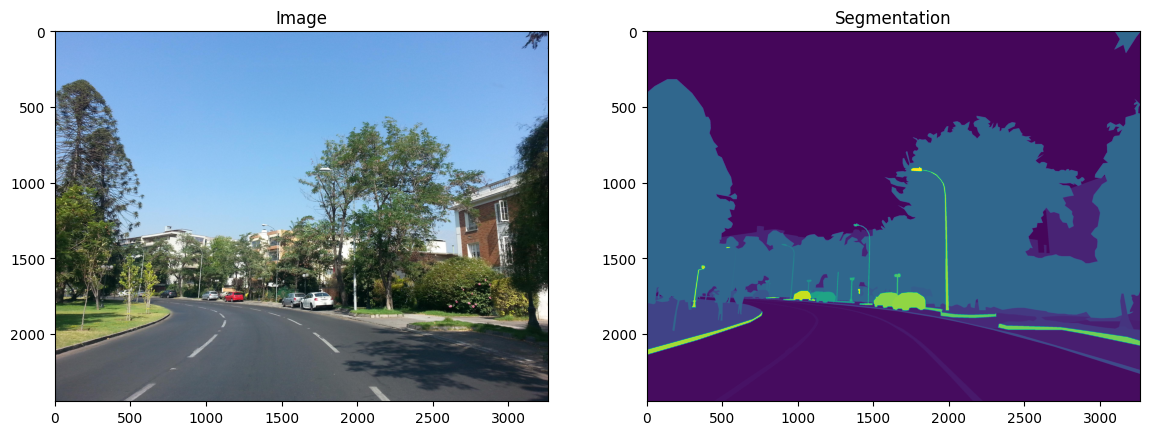

In [3]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--NSVcUgfVhFd6uzkqHOOg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--NSVcUgfVhFd6uzkqHOOg.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--SWG8TJo7vrbZ_x5YLj6A.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--SWG8TJo7vrbZ_x5YLj6A.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--WOpVBuHlCygAUADkttpg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--WOpVBuHlCygAUADkttpg.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/images/--jRsD9anHdGxv4ZOCQktA.jpg', shape=(), dtype=string)
tf.Tensor(b'data/panoptic/--jRsD9anHdGxv4ZOCQktA.png', shape=(), dtype=string)


In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [7]:
def process_test_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128))
    return img

# Preprocess testing data
test_image_filenames = tf.constant(test_image_list)

# Convert to TensorFlow Dataset
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_filenames)

# Apply preprocessing function to the dataset
test_image_ds = test_image_ds.map(process_test_path)
num_classes = 256
def preprocess_labels(dataset, num_classes):
    def map_labels(image, label):
        label = tf.clip_by_value(label, 0, num_classes - 1)  # Clip to valid range
        return image, label
    return dataset.map(map_labels)

processed_image_ds = preprocess_labels(processed_image_ds, num_classes)

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters,
                  3,      
                  activation="relu",
                  padding="same",
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,   
                  activation="relu",
                  padding="same",
                  
                  kernel_initializer="he_normal")(conv)
   
    
  
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)     
    
    if max_pooling:
        next_layer = MaxPooling2D(
            pool_size = (2,2)
        )(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    # Upsample the expansive input
    up = Conv2DTranspose(
        n_filters,    
        3,    
        strides=2,
        padding="same")(expansive_input)
    
    # Calculate the size difference
    diff_height = contractive_input.shape[1] - up.shape[1]
    diff_width = contractive_input.shape[2] - up.shape[2]
    
    # Apply cropping to the contractive input to match dimensions
    if diff_height > 0 or diff_width > 0:
        contractive_input = Cropping2D(
            cropping=((diff_height // 2, diff_height - diff_height // 2),
                      (diff_width // 2, diff_width - diff_width // 2))
        )(contractive_input)
    
    # Concatenate the upsampled and contractive inputs
    merge = concatenate([up, contractive_input], axis=3)
    
    # Convolutional layers after merging
    conv = Conv2D(n_filters,   
                  3,    
                  activation="relu",
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  
                  3,   
                  activation="relu",
                  padding="same",
                  kernel_initializer='he_normal')(conv)
    return conv

In [10]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=256):
    inputs = Input(input_size)
    
    # Contracting path
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3) 
    cblock6 = conv_block(inputs=cblock5[0], n_filters=n_filters*32, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding path
    print("Shape before ublock7:", cblock6[0].shape)
    ublock7 = upsampling_block(cblock6[0], cblock5[1], n_filters*16)
    print("Shape after ublock7:", ublock7.shape)
    
    print("Shape before ublock8:", ublock7.shape)
    ublock8 = upsampling_block(ublock7, cblock4[1], n_filters*8)
    print("Shape after ublock8:", ublock8.shape)
    
    print("Shape before ublock9:", ublock8.shape)
    ublock9 = upsampling_block(ublock8, cblock3[1], n_filters*4)
    print("Shape after ublock9:", ublock9.shape)
    
    print("Shape before ublock10:", ublock9.shape)
    ublock10 = upsampling_block(ublock9, cblock2[1], n_filters*2)
    print("Shape after ublock10:", ublock10.shape)
    
    print("Shape before ublock11:", ublock10.shape)
    ublock11 = Conv2DTranspose(n_filters*1, 
                           kernel_size=(3, 3), 
                           strides=(1, 1), 
                           padding='same', 
                           activation='relu',
                           kernel_initializer='he_normal')(ublock10)

# Concatenate with cblock1's skip connection
    resized_ublock11 = UpSampling2D(size=(2, 2))(ublock11)  # Double the width dimension to match
    print("Shape after resizing ublock11:", resized_ublock11.shape)

# Concatenate with cblock1's skip connection
    ublock11 = tf.keras.layers.Concatenate()([resized_ublock11, cblock1[1]])
    print("Shape after ublock11:", ublock11.shape)

    # Final convolutional layers
    conv12 = Conv2D(n_filters,
                    3,
                    activation='relu',
                    padding='same',
                    kernel_initializer='he_normal')(ublock11)
    print("Shape after ublock12:", conv12.shape)
    
    # Add extra layers to adjust spatial dimensions to (48, 128)
    conv13 = Conv2D(n_classes,
                    1,
                    padding='same')(conv12)
    print("Shape after ublock13:", conv13.shape)
    
    # Upsample if required to match (48, 128)
    output = UpSampling2D(size=(1.5, 1))(conv13) if conv13.shape[1] < 48 else conv13
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    return model

In [11]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

Shape before ublock7: (None, 3, 4, 1024)
Shape after ublock7: (None, 6, 8, 512)
Shape before ublock8: (None, 6, 8, 512)
Shape after ublock8: (None, 12, 16, 256)
Shape before ublock9: (None, 12, 16, 256)
Shape after ublock9: (None, 24, 32, 128)
Shape before ublock10: (None, 24, 32, 128)
Shape after ublock10: (None, 48, 64, 64)
Shape before ublock11: (None, 48, 64, 64)
Shape after resizing ublock11: (None, 96, 128, 32)
Shape after ublock11: (None, 96, 128, 64)
Shape after ublock12: (None, 96, 128, 32)
Shape after ublock13: (None, 96, 128, 256)


In [12]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 128, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 96, 128, 32)       │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 96, 128, 32)       │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 48, 64, 32)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 48, 64, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 48, 64, 64)        │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 24, 32, 64)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 24, 32, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 24, 32, 128)       │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 12, 16, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 12, 16, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 12, 16, 256)       │         590,080 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 6, 8, 256)         │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 6, 8, 512)         │       1,180,160 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 6, 8, 512)         │       2,359,808 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 6, 8, 512)         │               

 Total params: 34,585,504 (131.93 MB)

 Trainable params: 34,585,504 (131.93 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Cast y_true to the same data type as y_pred_labels
    y_true = tf.cast(y_true, y_pred_labels.dtype)
    # Compare predicted labels to true labels and compute accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    return accuracy




def mean_iou(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Compute IoU for each class
    iou = []
    for i in range(1, 66):  # Excluding background class 0
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        iou.append((intersection + 1e-7) / (union + 1e-7))  # Add small epsilon to avoid division by zero
    # Compute mean IoU across classes
    mean_iou = tf.reduce_mean(iou)
    return mean_iou


def precision(y_true, y_pred):
    """
    Compute Precision for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Precision as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # Convert logits to class labels
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)  # Shape (batch_size, height, width)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    # Exclude background class (0)
    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    predicted_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_pred_labels, 0), tf.float32))
    
    return true_positive / (predicted_positive + 1e-7)  # Avoid division by zero

def recall(y_true, y_pred):
    """
    Compute Recall.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Recall as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    actual_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))  # Exclude background
    return true_positive / (actual_positive + 1e-7)  # Avoid division by zero


def f1_score(y_true, y_pred):
    """
    Compute F1 Score for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        F1 Score as a scalar.
    """
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-7)


# Compile the model with pixel accuracy as an evaluation metric
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[pixel_accuracy,precision,recall])

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(3024, 4032, 1)


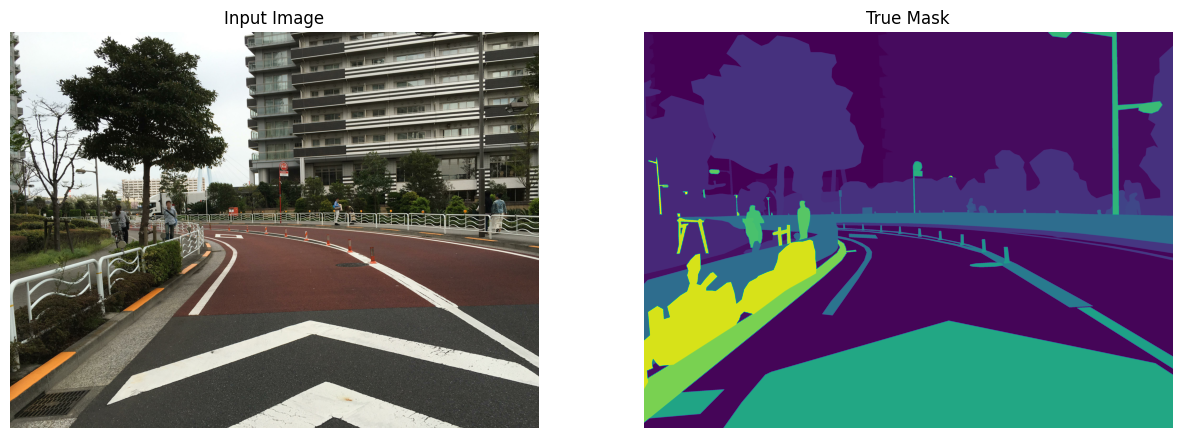

In [15]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


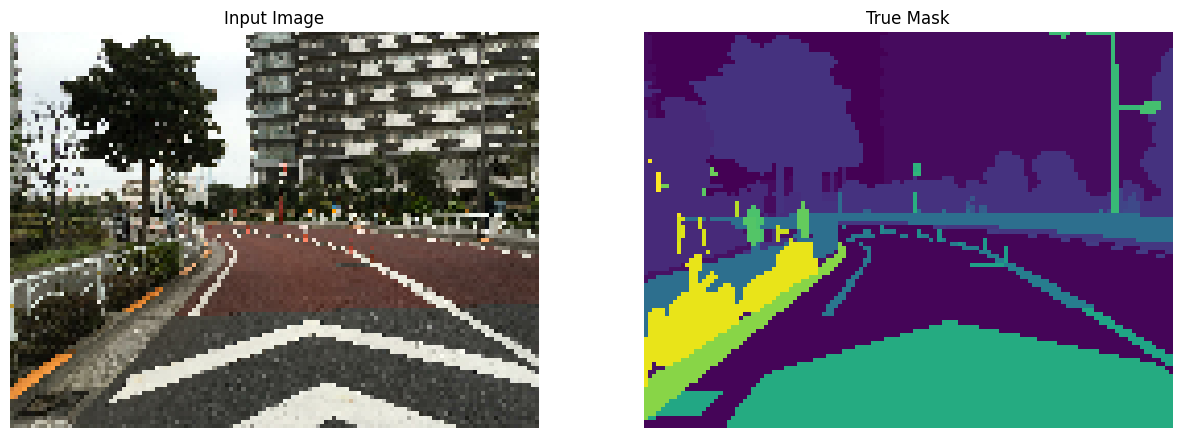

In [16]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [17]:
EPOCHS =150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 4
train_dataset = (
    processed_image_ds
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Check the dataset structure
print(train_dataset.element_spec)

# Train the model
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 549ms/step - loss: 5.5809 - pixel_accuracy: 0.1227 - precision: 0.1228 - recall: 0.1229
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - loss: 3.8891 - pixel_accuracy: 0.2795 - precision: 0.2795 - recall: 0.2798
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - loss: 3.4461 - pixel_accuracy: 0.2804 - precision: 0.2804 - recall: 0.2807
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - loss: 3.2154 - pixel_accuracy: 0.2809 - precision: 0.2809 - recall: 0.2811
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - loss: 3.1152 - pixel_accuracy: 0.2801 - precision: 0.2801 - recall: 0.2803
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - loss: 3.0666 - pixel_accuracy: 0.2837 - precision: 0.2837 - recall: 0.2839
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - loss: 3.0478 - pixel_accu

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


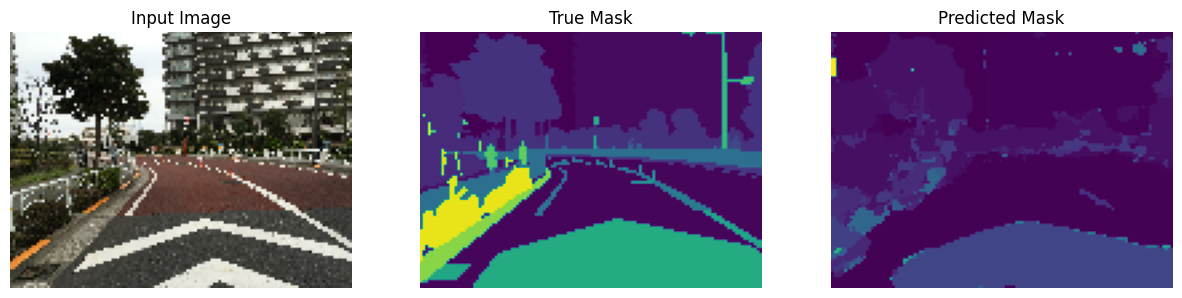

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


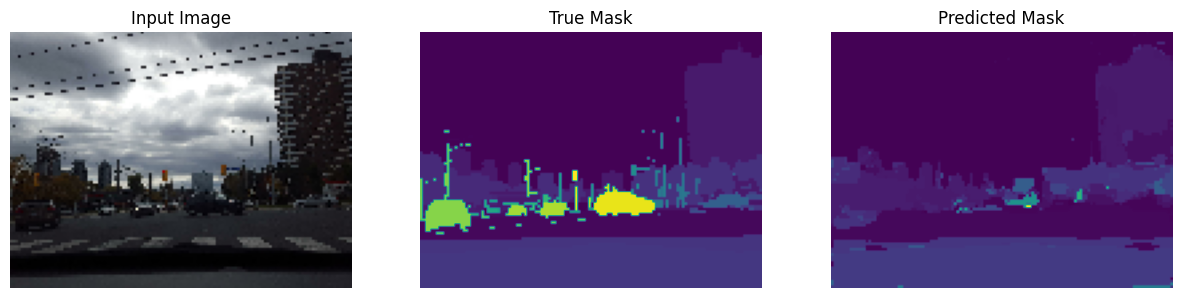

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


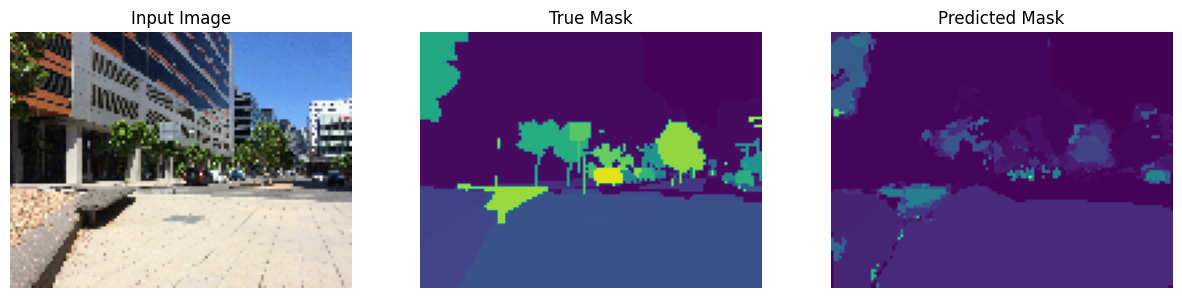

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


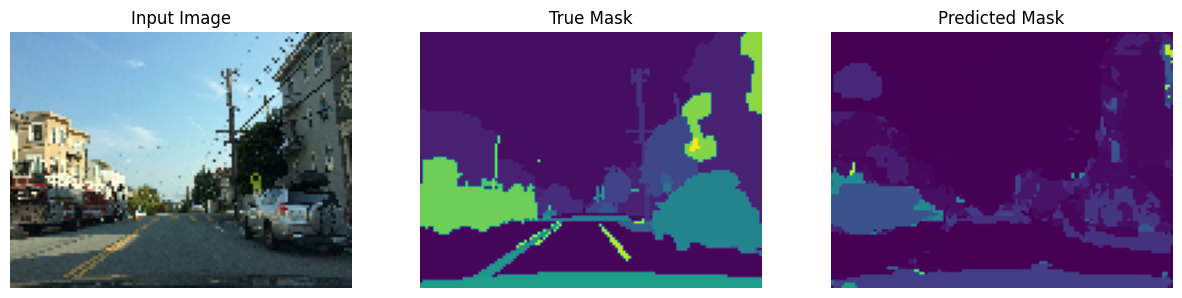

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


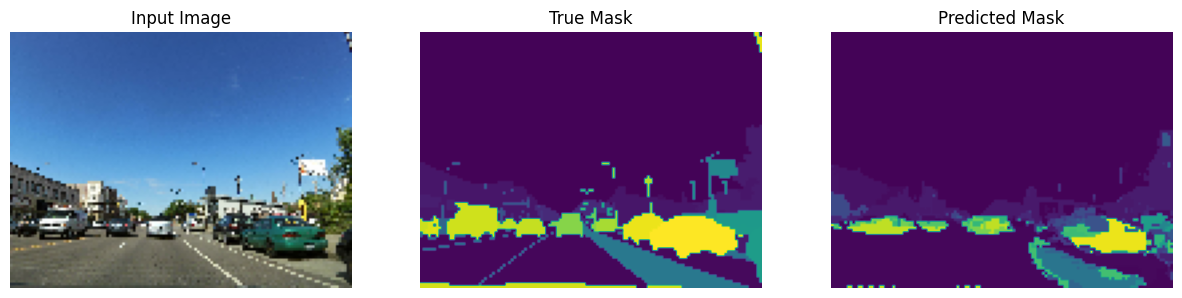

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


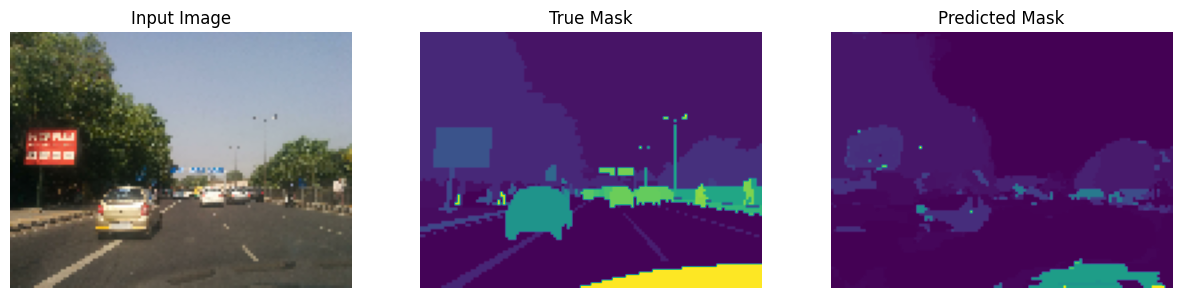

In [21]:
show_predictions(train_dataset, 6)

In [22]:
def visualize_results(test_images, predictions):
    for i in range(len(test_images)):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Test Image')
        plt.imshow(test_images[i])
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Predicted Mask')
        predicted_mask = create_mask(predictions[i])  # Use create_mask function here
        plt.imshow(predicted_mask, cmap='viridis')
        plt.axis('off')

        plt.show()

In [ ]:
import os
import cv2  # Assuming you're using OpenCV to load images
import numpy as np
import tensorflow as tf

# Assuming test_masks_folder contains the ground truth masks
test_masks_folder = "test_masks"

# Load ground truth masks
true_masks = []
for image_path in test_image_list:
    mask_path = os.path.join(test_masks_folder, os.path.basename(image_path))
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_masks.append(true_mask)

# Make predictions using the trained model
pred_masks = []
for test_image in test_image_ds.take(len(test_image_list)):
    test_image = test_image[tf.newaxis, ...]
    pred_mask = unet.predict(test_image)
    pred_masks.append(pred_mask)

def create_rgb_mask(mask):
    """
    Converts a single-channel mask to a three-channel RGB mask
    """
    return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

def convert_mask_color(mask, color_scheme):
    """
    Converts a mask's color scheme according to the given color_scheme dictionary
    """
    converted_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty RGB mask
    for value in color_scheme:
        converted_mask[mask == value] = color_scheme[value]
    return converted_mask

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def show_test_predictions(test_images_preprocessed, pred_masks, true_masks, num=1):
    """
    Displays the first num images of the test set along with predicted and ground truth masks
    """
    cmap = plt.cm.viridis  # Use the 'viridis' colormap

    for i, (test_image, pred_mask, true_mask) in enumerate(zip(test_images_preprocessed, pred_masks, true_masks)):
        if i >= num:
            break
        
        display_list = [test_image, create_mask(pred_mask), true_mask]
        title = ['Test Image', 'Predicted Mask', 'True Mask']
        display(display_list, title, cmap)

def display(display_list, title=None, cmap=None):
    """
    Displays a list of images with their corresponding titles
    """
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if cmap is not None and i == len(display_list) - 1:  # Apply colormap only to the last image
            plt.imshow(display_list[i], cmap=cmap)
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

# Display predictions for the test set along with ground truth
show_test_predictions(test_image_ds, pred_masks, true_masks, num=17)


In [ ]:
def save_ghostunet_model(model, save_path):
    """
    Save the GhostUNet model in Keras format
    
    Args:
        model (tf.keras.Model): The trained GhostUNet model
        save_path (str): Filepath to save the model
    """
    import os
    
    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save in Keras format
    model.save(save_path)
    print(f"Model saved to: {save_path}")

In [ ]:
save_ghostunet_model(model, './unet_saved_model/unet_model.keras')